In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")  # 忽略警告信息，用于清理输出

# 读取数据

In [ ]:
target = 'pos_index'
name = 'pos_index'
path = r'data/pos_index'
path_name = os.path.join(path,'pos_index.csv')
print('数据路径：',path_name)
print('预测目标：',target)

In [ ]:
df = pd.read_csv(path_name)
df

# ACF，PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df[target])
plt.show()

In [ ]:
plot_pacf(df[target])
plt.show()

In [32]:
"""
在做ARIMA（自回归整合移动平均模型）的时候，需要确定以下三个参数：
p：自回归项的阶数。这个参数需要通过观察自相关图（ACF）和偏自相关图（PACF）来确定。一般来说，如果PACF在某个点上截尾，那么这个点就可以作为p的取值。
这个参数代表了模型中自回归部分的阶数，也就是过去的观测值对当前观测值影响的滞后期数。例如，如果p=3，那么就表示当前的观测值可能受到前三期观测值的影响。
d：差分次数，即使得时间序列变为平稳的最小差分次数。这个参数的选取通常是基于单位根检验（如ADF检验或KPSS检验）。如果原始序列是平稳的，则d=0；否则，需要对序列进行一次或多次差分，直到差分序列平稳，并且差分的次数就是d的取值。
q：移动平均项的阶数。这个参数的选取也是通过观察ACF和PACF来确定。一般来说，如果ACF在某个点上截尾，那么这个点就可以作为q的取值。
这个参数代表了模型中移动平均部分的阶数，也就是过去的误差项对当前观测值影响的滞后期数。例如，如果q=2，那么就表示当前的观测值可能受到前两期误差项的影响。
"""

'\n在做ARIMA（自回归整合移动平均模型）的时候，需要确定以下三个参数：\np：自回归项的阶数。这个参数需要通过观察自相关图（ACF）和偏自相关图（PACF）来确定。一般来说，如果PACF在某个点上截尾，那么这个点就可以作为p的取值。\n这个参数代表了模型中自回归部分的阶数，也就是过去的观测值对当前观测值影响的滞后期数。例如，如果p=3，那么就表示当前的观测值可能受到前三期观测值的影响。\nd：差分次数，即使得时间序列变为平稳的最小差分次数。这个参数的选取通常是基于单位根检验（如ADF检验或KPSS检验）。如果原始序列是平稳的，则d=0；否则，需要对序列进行一次或多次差分，直到差分序列平稳，并且差分的次数就是d的取值。\nq：移动平均项的阶数。这个参数的选取也是通过观察ACF和PACF来确定。一般来说，如果ACF在某个点上截尾，那么这个点就可以作为q的取值。\n这个参数代表了模型中移动平均部分的阶数，也就是过去的误差项对当前观测值影响的滞后期数。例如，如果q=2，那么就表示当前的观测值可能受到前两期误差项的影响。\n'

In [33]:
"""
ADF检验，全称Augmented Dickey-Fuller unit root test，也就是扩展迪基-福勒单位根检验，是一种常用的检验时间序列数据是否平稳的方法。

在ADF检验中，我们主要看检验的P值。P值是一个统计学概念，表示观察到的数据与零假设之间的兼容性。零假设通常是我们想要反驳的假设，对于ADF检验来说，零假设就是数据序列是非平稳的。

P值的范围是0到1。如果P值小于我们设定的显著性水平（例如0.05），那么我们就拒绝零假设，认为数据是平稳的。如果P值大于我们设定的显著性水平，那么我们就无法拒绝零假设，认为数据是非平稳的。
"""
def adf_test(series, signif=0.05):
    result = adfuller(series, autolag='AIC')
    pvalue = result[1]
    return pvalue

pvalue1 = adf_test(df[target])
pvalue1

3.3754740976975143e-15

In [34]:
X = df[target].values
# 将数据集分为训练集和测试集
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

# AIC and BIC

In [35]:
# 定义参数范围
p = d = q = range(0, 3)  # AR, I, MA参数从0到2

# 生成所有可能的参数组合
parameters = list(product(p, d, q))
parameters = [(p,d,q) for (p,d,q) in parameters]
parameters

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [36]:
best_aic_bic = float("inf")
best_params = None
results = []

# 尝试不同的参数组合
for param in parameters:
    try:
        model = ARIMA(history, order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        bic = model_fit.bic
        results.append((param, aic))
        if np.mean([aic,bic]) < best_aic_bic:
            best_aic_bic = aic
            best_params = param
    except:
        continue  # 如果模型未能拟合，则继续尝试其他参数组合
best_params,best_aic_bic

((1, 0, 2), 3039.1741661524575)

# 通过ARIMA进行训练

In [37]:
import time
start_time = time.time()
model = ARIMA(history, order=best_params)
model_fit = model.fit()
end_time = time.time()
print('Time: ', end_time - start_time)

Time:  0.18900609016418457


# 通过ARIMA进行预测

In [38]:
X = df[target].values
# 将数据集分为训练集和测试集
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = []
# 拟合ARIMA模型并进行预测
for t in range(len(test)):
    model = ARIMA(history, order=best_params)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


In [41]:
# predictions = model_fit.forecast(len(test))

In [42]:


dff = pd.DataFrame()
dff['预测值'] = predictions
dff['真实值'] = df.iloc[-len(predictions):,1].values
dff.index = df.iloc[-len(predictions):,0]
dff.to_csv('测试集预测结果_{}.csv'.format(name))
dff

,预测值,真实值
date,,
2016-11-27,4.111590,3.015448
2016-12-04,2.977334,2.920078
2016-12-11,3.111248,2.725051
2016-12-18,3.047026,2.437357
2016-12-25,2.612466,1.350290
...,...,...
2019-12-01,0.841178,0.442865
2019-12-08,0.969759,0.380980
2019-12-15,0.832413,0.840110


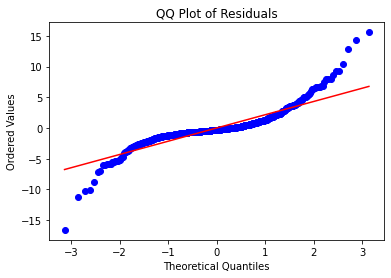

In [43]:
import scipy.stats as stats
# 获取残差
residuals = model_fit.resid

# 使用 scipy 的 probplot 方法生成 QQ 图数据
stats.probplot(residuals, dist="norm", plot=plt)

# 显示图形
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.savefig('残差qq图_{}_{}.jpg'.format(name,target),dpi=150)
plt.show()

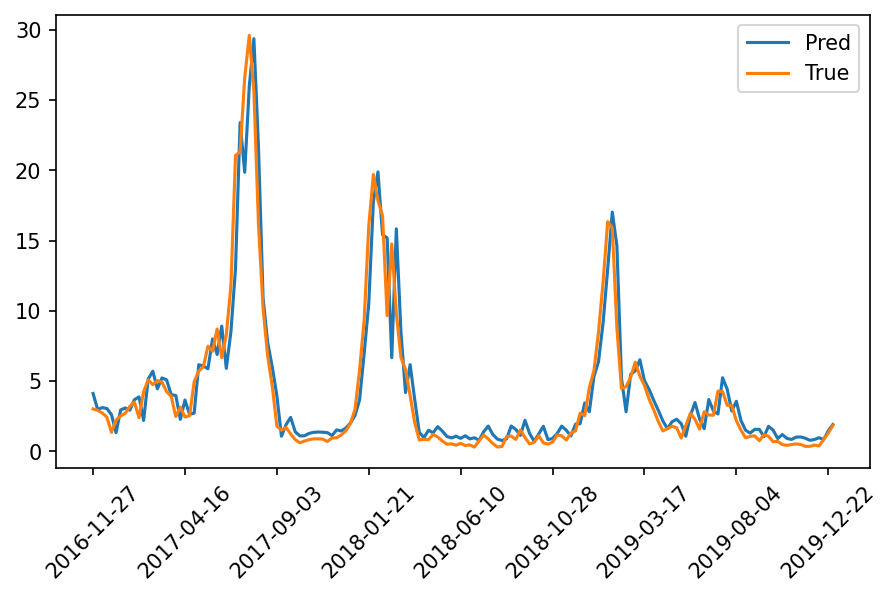

In [44]:
plt.figure(dpi=150,figsize=(7,4))
plt.plot(dff['预测值'],label='Pred')
plt.plot(dff['真实值'],label = 'True')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.AutoLocator())
# tick_spacing = 3
# plt.xticks(ticks=range(0, len(dff), tick_spacing), rotation=45)
plt.legend()
plt.savefig('测试集对比图{}_{}.jpg'.format(name,target),dpi=150)
plt.show()

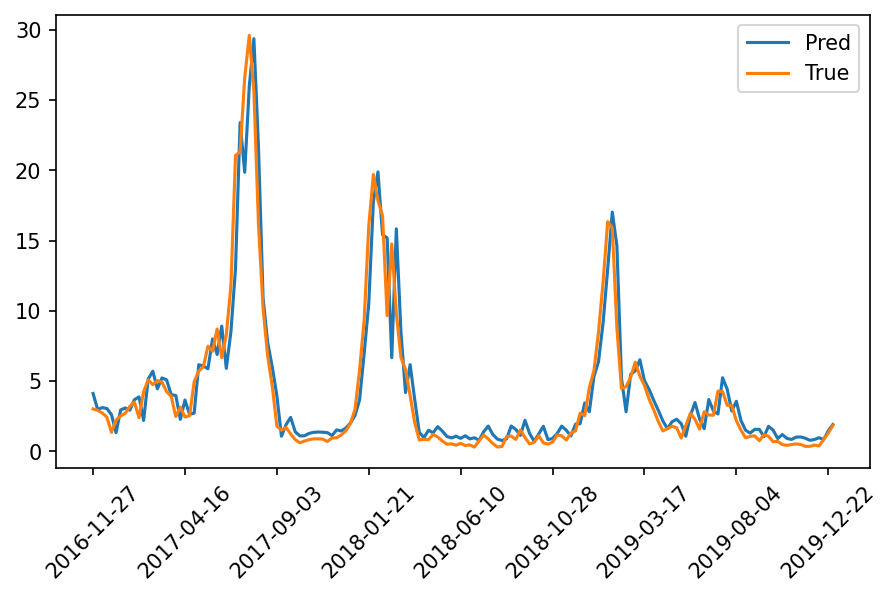

In [45]:
plt.figure(dpi=150,figsize=(7,4))
plt.plot(dff['预测值'],label='Pred')
plt.plot(dff['真实值'],label = 'True')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.AutoLocator())
# tick_spacing = 3
# plt.xticks(ticks=range(0, len(dff), tick_spacing), rotation=45)
plt.legend()
plt.savefig('测试集对比图{}_{}.jpg'.format(name,target),dpi=150)
plt.show()

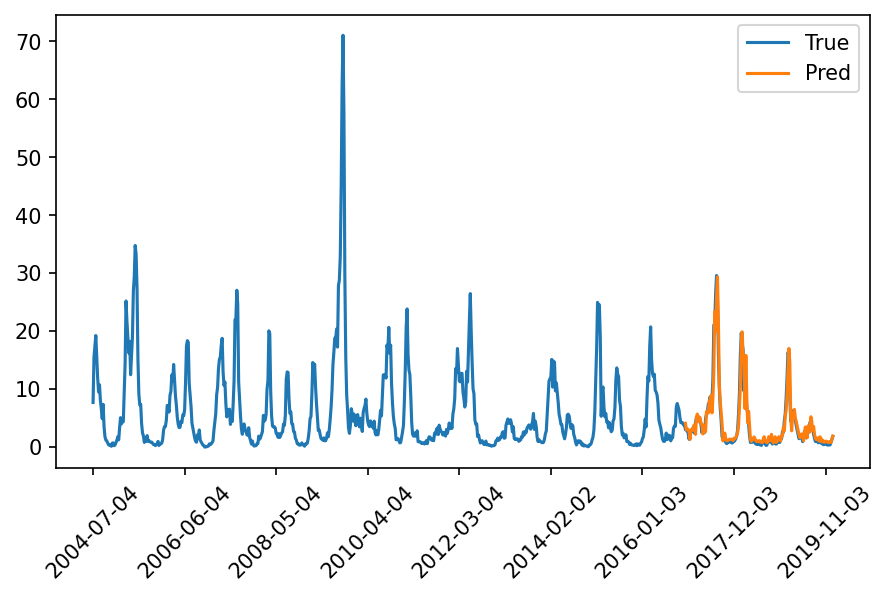

In [46]:
df.index = df.iloc[:,0]
plt.figure(dpi=150, figsize=(7, 4))
plt.plot(df.iloc[:,1],label='True')
plt.plot(dff['预测值'],label='Pred')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.AutoLocator())
# tick_spacing = 3
# plt.xticks(ticks=range(0, len(dff), tick_spacing), rotation=45)
plt.legend()
plt.savefig('对比图{}_{}.jpg'.format(name,target),dpi=150)
plt.show()

# 评估指标

In [47]:
def Evaluation_index(Y_test1,pre):
    from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score,mean_absolute_error
    r2 = r2_score(Y_test1,pre)
    ev = explained_variance_score(Y_test1,pre)
    mse = mean_squared_error(Y_test1,pre)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test1,pre)

    pre = pre.reshape(-1)
    Y_test1 = Y_test1.reshape(-1)
    INDEX = []
    page = 0
    for i in Y_test1:
        if i ==0:
            INDEX.append(page)
        page +=1
    if INDEX !=[]:
        Y_test1 = np.delete(Y_test1,INDEX,0)
        pre     = np.delete(pre,INDEX,0)
    mape = (sum(abs((pre - Y_test1)/(Y_test1)))/len(Y_test1))
    print('r2:',r2)
    print('ev:',ev)
    print('mse:',mse)
    print('rmse:',rmse)
    print('mae:',mae)
    print('mape:',mape)
# def z_score(data):
#     data = data.astype(float)
#     Mean = data.mean()
#     Var = ((data - Mean)**2).mean()
#     Std = pow(Var,0.5)
#     data = (data - Mean)/Std  # 标准化
#     return Mean,Std,data
# Mean,Std,_ = z_score(train)
# Evaluation_index((dff['真实值'].values - Mean)/Std,(predictions - Mean)/Std)
Evaluation_index(dff['真实值'].values,np.array(predictions))

r2: 0.8880330715333855
ev: 0.8890586854827428
mse: 3.293347500657803
rmse: 1.8147582485438116
mae: 1.1230163198109737
mape: 0.47797942446287733
